<a href="https://colab.research.google.com/github/JeiGeek/ia1-LosPandas-prediccion_rendimiento_estudiantil/blob/main/03_Unsupervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
# @title **Librerias**
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import random
import os
from mpl_toolkits.mplot3d import Axes3D

# Partición de dataset
from sklearn.model_selection import train_test_split

# Particion de entrenamiento KFol y tunning
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate, GridSearchCV, KFold, RandomizedSearchCV

# Librerias de modelos
from sklearn.svm import SVR

# Deep learning
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Nosupervisado
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# Librerias para reporte de metricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, balanced_accuracy_score, matthews_corrcoef, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error

# **Carga del dataset y configuraciones**

In [2]:
# Carga desde github
url = "https://raw.githubusercontent.com/JeiGeek/ia1-LosPandas-prediccion_rendimiento_estudiantil/main/Dataset/StudentPerformanceFactors.csv"
df = pd.read_csv(url)

In [3]:
# Limpieza de nulos y valores fuera del margen
df = df.dropna()
df = df[df['Exam_Score'] <= 100]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6377 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6377 non-null   int64 
 1   Attendance                  6377 non-null   int64 
 2   Parental_Involvement        6377 non-null   object
 3   Access_to_Resources         6377 non-null   object
 4   Extracurricular_Activities  6377 non-null   object
 5   Sleep_Hours                 6377 non-null   int64 
 6   Previous_Scores             6377 non-null   int64 
 7   Motivation_Level            6377 non-null   object
 8   Internet_Access             6377 non-null   object
 9   Tutoring_Sessions           6377 non-null   int64 
 10  Family_Income               6377 non-null   object
 11  Teacher_Quality             6377 non-null   object
 12  School_Type                 6377 non-null   object
 13  Peer_Influence              6377 non-null   object
 1

In [4]:
# Hay 13 variables de tipo categoricas, se convierten en tipo numericas (se le da un valor ya sea 0 y 1, o 1,2,3)

df_encoded = df.copy()

# Categorizacion binaria para categorias que son solo 2 dos tipos

# get_dummies - Convierte tablas categoricas en binarios
# drop_first - quita la columna redudante que se genera
df_encoded = pd.get_dummies(df_encoded, columns=["Extracurricular_Activities", "Internet_Access", "School_Type", "Learning_Disabilities", "Gender"], drop_first=True)

# Categorizacion por categorias que son de 3 tipos

# para categorias bajo - medio - alto
mapping = {"Low":1, "Medium":2, "High":3}
columnas = ["Parental_Involvement", "Access_to_Resources", "Motivation_Level", "Family_Income", "Teacher_Quality"]

for columna in columnas:
    df_encoded[columna] = df_encoded[columna].map(mapping)

# para categoria negativo - positivo - neutral
mapping = {"Negative":-1, "Positive":1, "Neutral":0}
df_encoded["Peer_Influence"] = df_encoded["Peer_Influence"].map(mapping)

# para categoria High School - College - Postgraduate
mapping = {"High School":1, "College":2, "Postgraduate":3}
df_encoded["Parental_Education_Level"] = df_encoded["Parental_Education_Level"].map(mapping)

# para categoria Near - Moderate - Far
mapping = {"Near":1, "Moderate":2, "Far":3}
df_encoded["Distance_from_Home"] = df_encoded["Distance_from_Home"].map(mapping)


# Convertir las columnas booleanas resultantes en 0 y 1
bool_cols = df_encoded.select_dtypes(include=["bool"]).columns # Se seleccionan las columnas solamente las columnas booleanas
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int) # Se convierten en 0 y 1

# **Aprendizaje no supervisado**

In [36]:
# @title Preparación del dataset

df_r = df_encoded.copy()

# Variables predictoras
X = df_r.drop(['Exam_Score'], axis=1)

# Variable objetivo (solo para análisis al final, clustering no usa y)
y = df_r['Exam_Score']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# En formato DataFrame para comodidad
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

X_scaled_df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Sleep_Hours,Previous_Scores,Motivation_Level,Tutoring_Sessions,Family_Income,Teacher_Quality,Peer_Influence,Physical_Activity,Parental_Education_Level,Distance_from_Home,Extracurricular_Activities_Yes,Internet_Access_Yes,School_Type_Public,Learning_Disabilities_Yes,Gender_Male
0,0.505278,0.344803,-1.562297,1.290854,-0.023928,-0.143302,-1.305379,-1.212085,-1.059809,-0.327989,1.068816,0.026518,-0.903890,-0.751306,-1.216700,0.286586,0.662215,-0.342065,0.853886
1,-0.163081,-1.387019,-1.562297,-0.140510,0.657282,-1.115616,-1.305379,0.409708,0.285414,-0.327989,-1.575545,0.998406,0.377307,0.740312,-1.216700,0.286586,0.662215,-0.342065,-1.171116
2,0.672367,1.557079,-0.123215,-0.140510,-0.023928,1.106816,0.132093,0.409708,0.285414,-0.327989,-0.253364,0.998406,1.658505,-0.751306,0.821896,0.286586,0.662215,-0.342065,0.853886
3,1.507815,0.777759,-1.562297,-0.140510,0.657282,1.592974,0.132093,-0.401188,0.285414,-0.327989,-1.575545,0.998406,-0.903890,0.740312,0.821896,0.286586,0.662215,-0.342065,0.853886
4,-0.163081,1.037532,-0.123215,-0.140510,-0.705139,-0.698910,0.132093,1.220605,0.285414,1.335960,-0.253364,0.998406,0.377307,-0.751306,0.821896,0.286586,0.662215,-0.342065,-1.171116


## **K-MEANS**



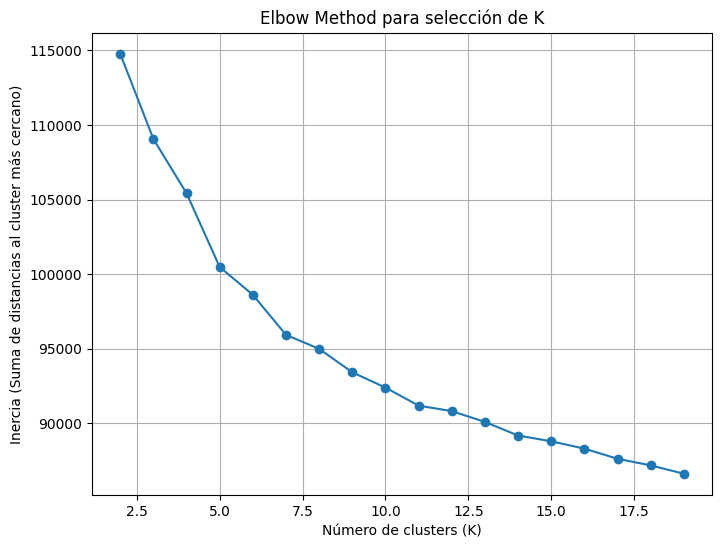

In [38]:
# @title Aplicación de **ELBOW METHOD**
inertias = []
K_values = range(2, 20)

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled_df)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8,6))
plt.plot(K_values, inertias, marker='o')
plt.title("Elbow Method para selección de K")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inercia (Suma de distancias al cluster más cercano)")
plt.grid(True)
plt.show()

En el gráfico se visualiza el codo entre 6 y 7 por ende la elección de cluster puede ser k = 6 o k = 7

In [66]:
# @title Entrenamiento de K-Means
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled_df)

kmeans_labels[:10]  # ver los primeros clusters asignados

array([1, 1, 2, 3, 0, 2, 3, 3, 1, 3], dtype=int32)

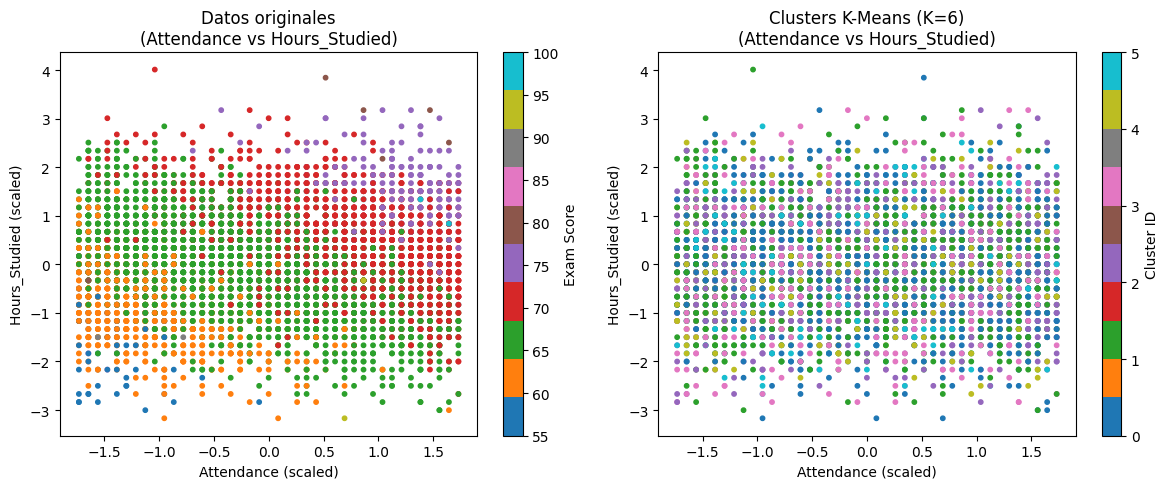

In [67]:
# @title Gráficación 2D de los datos a partir de las variables de mejor correlación

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# SUBPLOT 1: Datos originales
scatter1 = ax[0].scatter(
    X_scaled_df['Attendance'],
    X_scaled_df['Hours_Studied'],
    c=y,
    cmap='tab10',
    s=10
)

ax[0].set_title("Datos originales\n(Attendance vs Hours_Studied)")
ax[0].set_xlabel("Attendance (scaled)")
ax[0].set_ylabel("Hours_Studied (scaled)")
cbar1 = fig.colorbar(scatter1, ax=ax[0])
cbar1.set_label("Exam Score")

# SUBPLOT 2: KMeans clusters
scatter2 = ax[1].scatter(
    X_scaled_df['Attendance'],
    X_scaled_df['Hours_Studied'],
    c=kmeans_labels,
    cmap='tab10',
    s=10
)

ax[1].set_title("Clusters K-Means (K=6)\n(Attendance vs Hours_Studied)")
ax[1].set_xlabel("Attendance (scaled)")
ax[1].set_ylabel("Hours_Studied (scaled)")
cbar2 = fig.colorbar(scatter2, ax=ax[1])
cbar2.set_label("Cluster ID")

plt.tight_layout()
plt.show()

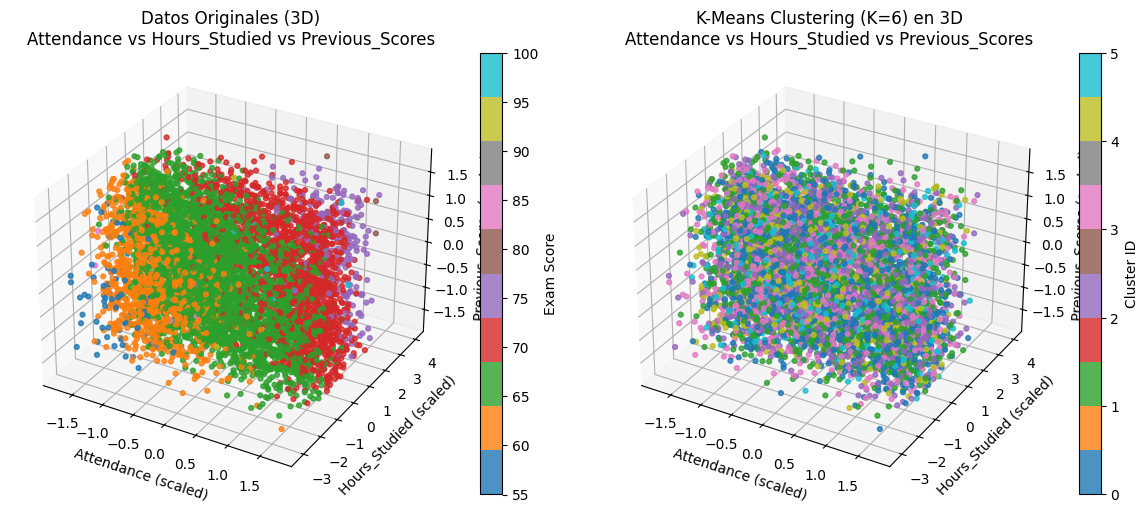

In [110]:
# @title Gráficación 3D de los datos a partir de las variables de mejor correlación

# Variables base
att = X_scaled_df['Attendance']
hrs = X_scaled_df['Hours_Studied']
prev = X_scaled_df['Previous_Scores']

fig = plt.figure(figsize=(12, 5))


# SUBPLOT 1: Datos Originales en 3D
ax1 = fig.add_subplot(121, projection='3d')

scatter1 = ax1.scatter(
    att,
    hrs,
    prev,
    c=y,               # color por nota real
    cmap='tab10',
    s=12,
    alpha=0.8
)

ax1.set_title("Datos Originales (3D)\nAttendance vs Hours_Studied vs Previous_Scores")
ax1.set_xlabel("Attendance (scaled)")
ax1.set_ylabel("Hours_Studied (scaled)")
ax1.set_zlabel("Previous_Scores (scaled)")

cbar1 = fig.colorbar(scatter1, ax=ax1)
cbar1.set_label("Exam Score")


# SUBPLOT 2: K-Means Clustering en 3D
ax2 = fig.add_subplot(122, projection='3d')

scatter2 = ax2.scatter(
    att,
    hrs,
    prev,
    c=kmeans_labels,       # color por cluster
    cmap='tab10',
    s=12,
    alpha=0.8
)

ax2.set_title("K-Means Clustering (K=6) en 3D\nAttendance vs Hours_Studied vs Previous_Scores")
ax2.set_xlabel("Attendance (scaled)")
ax2.set_ylabel("Hours_Studied (scaled)")
ax2.set_zlabel("Previous_Scores (scaled)")

cbar2 = fig.colorbar(scatter2, ax=ax2)
cbar2.set_label("Cluster ID")

plt.tight_layout()
plt.show()

In [63]:
# @title Score para K-Means
silhouette_kmeans = silhouette_score(X_scaled_df, kmeans_labels)
print("Score: ",silhouette_kmeans)

Score:  0.05731883775192859


Se utilizará como métrica de evaluación Silhouette Score ya que nos ayuda diciendo ¿Qué tan compactos son los clusters? y ¿Qué tan separados están entre sí?

<h3> <b> Análisis </b> </h3>

El algoritmo K-Means fue ajustado usando K = 6, seleccionado mediante el método del codo, donde se observó un cambio de pendiente significativo en la inercia alrededor de 6 y 7 clusters. Sin embargo, al proyectar los datos en dos variables altamente correlacionadas con el desempeño académico (Attendance y Hours_Studied), se observa que los estudiantes se distribuyen de forma continua, sin separaciones naturales claras. Esto ya dice mucho sobre que K-Means no encontrará grupos muy definidos.

El Silhouette Score obtenido (0.057) confirma esto, que los valores cercanos a cero indican que los clusters se superponen ampliamente, que la separación entre grupos es débil y que la estructura del dataset no presenta conglomerados bien formados. Entonces mientras que los datos originales muestran una relación más bien gradual entre asistencia, horas de estudio y puntaje, K-Means segmenta este espacio de forma relativamente arbitraria, dividiendo regiones donde no existen límites naturales.

## **DBSCAN**

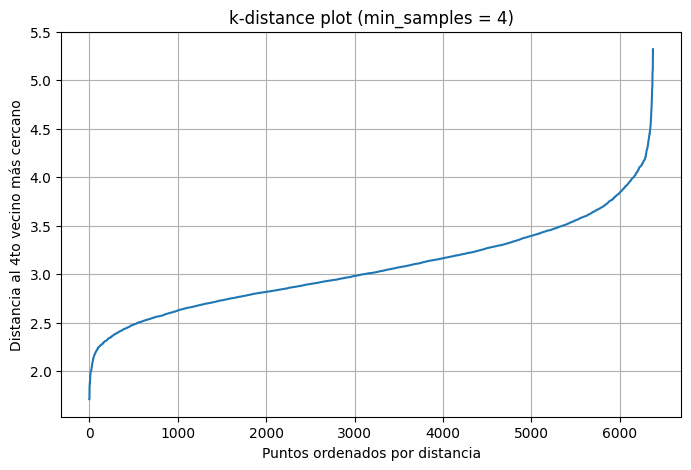

In [72]:
# @title Gráfico de **K-DISTANCE PLOT**

# Seleccionamos min_samples = 4 para el análisis
min_samples = 4

# Ajustamos Nearest Neighbors
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled_df)

# Distancias a los vecinos más cercanos
distances, indices = neighbors_fit.kneighbors(X_scaled_df)

# Tomamos la distancia al 4to vecino (columna -1)
distances_4 = np.sort(distances[:, -1])

plt.figure(figsize=(8,5))
plt.plot(distances_4)
plt.title("k-distance plot (min_samples = 4)")
plt.ylabel("Distancia al 4to vecino más cercano")
plt.xlabel("Puntos ordenados por distancia")
plt.grid(True)
plt.show()

* La parte plana corresponde a puntos en regiones densas.

* La parte donde la curva sube bruscamente indica el punto donde aparecen outliers o regiones menos densas.

* Ese cambio brusco es el “codo”, la mejor estimación para eps (En este caso eps = 4).

In [75]:
# @title Entrenamiento de DBSCAN

dbscan = DBSCAN(eps=4, min_samples=4)
dbscan_labels = dbscan.fit_predict(X_scaled_df)

# Clusters que encontró
unique, counts = np.unique(dbscan_labels, return_counts=True)
list(zip(unique, counts))

[(np.int64(-1), np.int64(69)),
 (np.int64(0), np.int64(6288)),
 (np.int64(1), np.int64(7)),
 (np.int64(2), np.int64(13))]

Ese **-1** que el DBSCAN encontró es la representación del ruido **(outliers)**

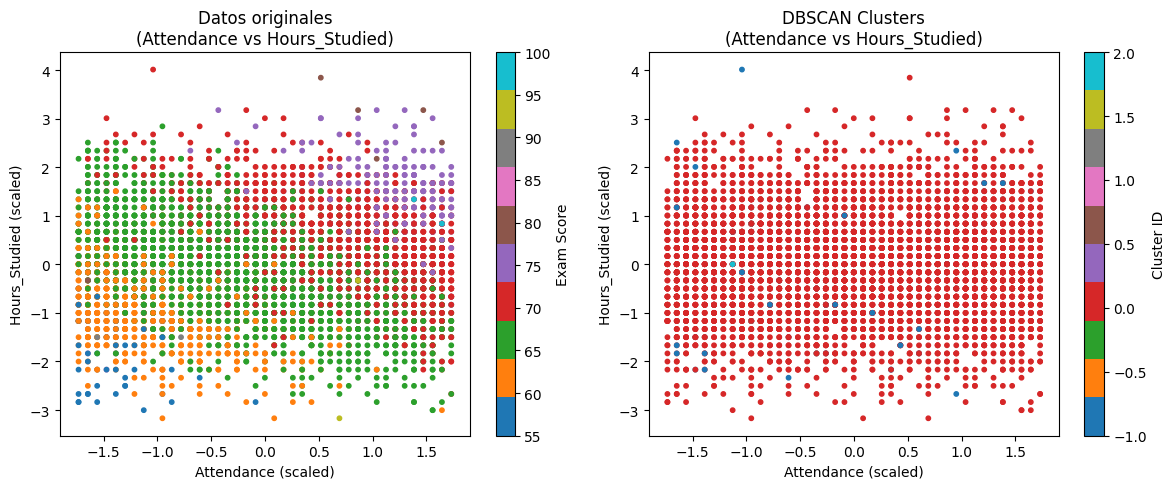

In [78]:
# @title Gráficación 2D de los datos a partir de las variables de mejor correlación
fig, ax = plt.subplots(1, 2, figsize=(12, 5))


# SUBPLOT 1: Datos originales
scatter1 = ax[0].scatter(
    X_scaled_df['Attendance'],
    X_scaled_df['Hours_Studied'],
    c=y,                      # color por Exam Score
    cmap='tab10',
    s=10
)

ax[0].set_title("Datos originales\n(Attendance vs Hours_Studied)")
ax[0].set_xlabel("Attendance (scaled)")
ax[0].set_ylabel("Hours_Studied (scaled)")
cbar1 = fig.colorbar(scatter1, ax=ax[0])
cbar1.set_label("Exam Score")


# SUBPLOT 2: Clusters DBSCAN
scatter2 = ax[1].scatter(
    X_scaled_df['Attendance'],
    X_scaled_df['Hours_Studied'],
    c=dbscan_labels,          # color por cluster DBSCAN
    cmap='tab10',
    s=10
)

ax[1].set_title("DBSCAN Clusters\n(Attendance vs Hours_Studied)")
ax[1].set_xlabel("Attendance (scaled)")
ax[1].set_ylabel("Hours_Studied (scaled)")
cbar2 = fig.colorbar(scatter2, ax=ax[1])
cbar2.set_label("Cluster ID")

plt.tight_layout()
plt.show()

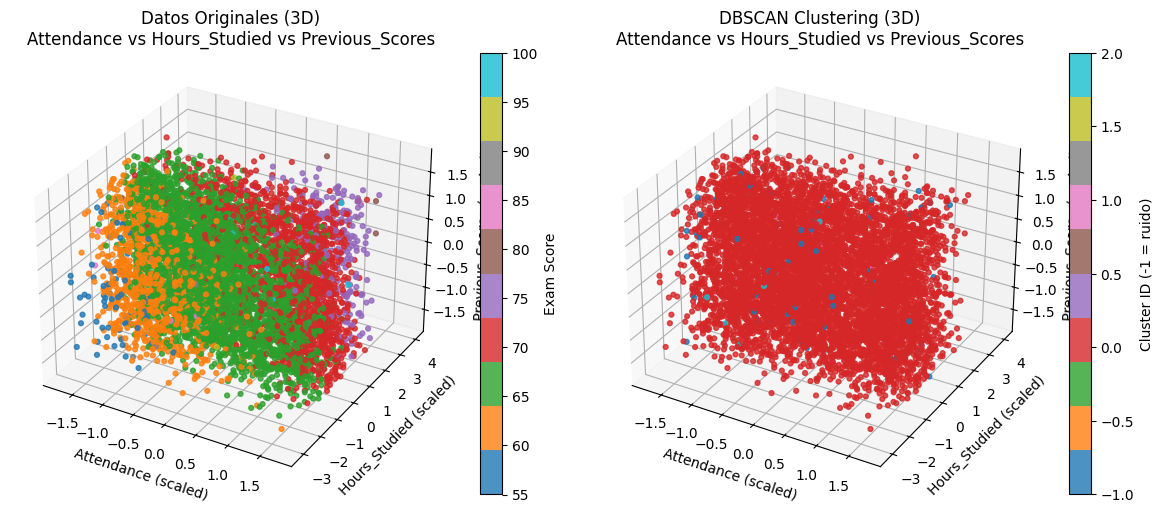

In [109]:
# @title Gráficación 3D de los datos a partir de las variables de mejor correlación

# Variables base
att = X_scaled_df['Attendance']
hrs = X_scaled_df['Hours_Studied']
prev = X_scaled_df['Previous_Scores']

fig = plt.figure(figsize=(12, 5))


# SUBPLOT 1: Datos Originales en 3D
ax1 = fig.add_subplot(121, projection='3d')

scatter1 = ax1.scatter(
    att,
    hrs,
    prev,
    c=y,               # color por nota real
    cmap='tab10',
    s=12,
    alpha=0.8
)

ax1.set_title("Datos Originales (3D)\nAttendance vs Hours_Studied vs Previous_Scores")
ax1.set_xlabel("Attendance (scaled)")
ax1.set_ylabel("Hours_Studied (scaled)")
ax1.set_zlabel("Previous_Scores (scaled)")

cbar1 = fig.colorbar(scatter1, ax=ax1)
cbar1.set_label("Exam Score")


# SUBPLOT 2: DBSCAN Clustering en 3D
ax2 = fig.add_subplot(122, projection='3d')

scatter2 = ax2.scatter(
    att,
    hrs,
    prev,
    c=dbscan_labels,       # color por cluster
    cmap='tab10',
    s=12,
    alpha=0.8
)

ax2.set_title("DBSCAN Clustering (3D)\nAttendance vs Hours_Studied vs Previous_Scores")
ax2.set_xlabel("Attendance (scaled)")
ax2.set_ylabel("Hours_Studied (scaled)")
ax2.set_zlabel("Previous_Scores (scaled)")

cbar2 = fig.colorbar(scatter2, ax=ax2)
cbar2.set_label("Cluster ID (-1 = ruido)")

plt.tight_layout()
plt.show()

In [91]:
# @title Score para Agglomerative Clustering
silhouette_dbscan = silhouette_score(X_scaled_df, dbscan_labels)
print("Score: ",silhouette_dbscan)

Score:  0.14940378815677882


<h3> <b> Análisis </b> </h3>
El método DBSCAN fue ajustado utilizando los hiperparámetros seleccionados mediante el k-distance plot, donde se observó un cambio brusco alrededor de una distancia de 4 unidades. Al aplicar el algoritmo, DBSCAN detectó un comportamiento característico de datasets sin densidades claramente diferenciadas, un cluster dominante que agrupa a la mayoría de los estudiantes (cluster 0 con 6288 puntos), un conjunto de puntos considerados ruido (69 observaciones asignadas al cluster -1), y dos clusters pequeños, extremadamente pequeños (7 y 13 puntos).

La visualización confirma que prácticamente todos los puntos aparecen en un mismo grupo, sin fronteras visibles entre segmentos significativos. Esto es coherente con la naturaleza de DBSCAN, el cual solo forma clusters cuando existen regiones de alta densidad separadas por zonas de baja densidad. En este caso, la distribución de los estudiantes es esencialmente continua en términos de asistencia y horas de estudio, lo que impide la formación de clusters bien definidos.

## **Agglomerative Clustering**

Para hacer legible el dendograma se usará un ejemplo de 500 puntos porque de lo contrario no se podrá observar bien.

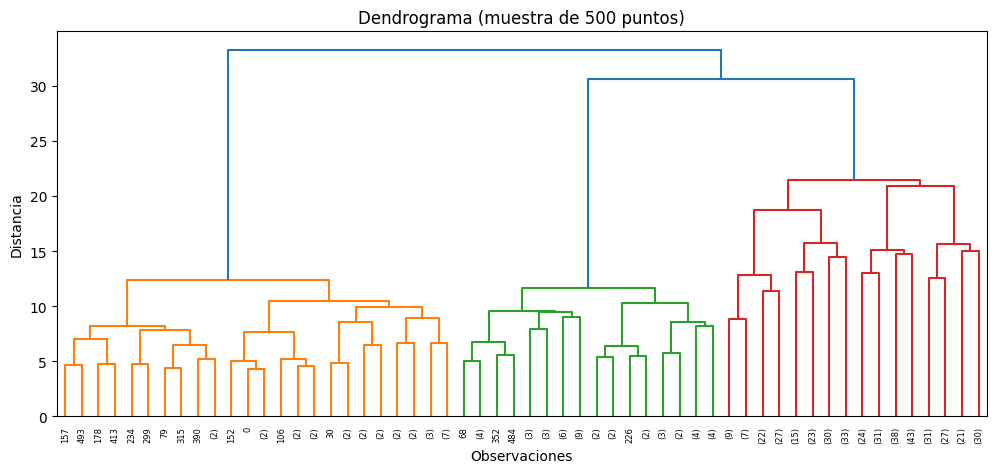

In [82]:
# @title Visualización del dendrograma

# Tomar una muestra aleatoria de 500 puntos
np.random.seed(42)
sample_indices = np.random.choice(len(X_scaled_df), size=500, replace=False)
X_sample = X_scaled_df.iloc[sample_indices]

# Matriz de linkage: ward
Z = linkage(X_sample, method='ward')

# Gráfica del dendrograma
plt.figure(figsize=(12, 5))
dendrogram(Z, truncate_mode='level', p=5)
plt.title("Dendrograma (muestra de 500 puntos)")
plt.xlabel("Observaciones")
plt.ylabel("Distancia")
plt.show()

En la obtención del clusters podemos observar ya sea
* Cortando alto: 2 clusters
* Cortando medio: 3 clusters
* Cortando bajo: 5–6 cluster

In [99]:
# @title Ajustar con 3 clusters
agg = AgglomerativeClustering(
    n_clusters=3,
    linkage='ward' # Minimiza la varianza dentro del cluster
)

agg_labels = agg.fit_predict(X_scaled_df)

agg_labels[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

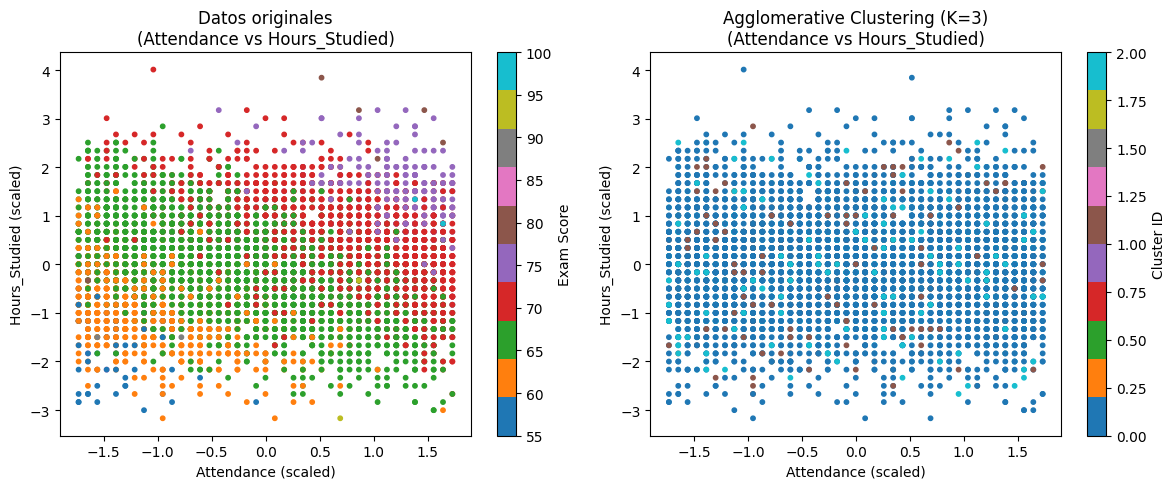

In [100]:
# @title Gráficación 2D de los datos a partir de las variables de mejor correlación
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# SUBPLOT 1: Datos originales
scatter1 = ax[0].scatter(
    X_scaled_df['Attendance'],
    X_scaled_df['Hours_Studied'],
    c=y,                      # color por Exam Score
    cmap='tab10',
    s=10
)

ax[0].set_title("Datos originales\n(Attendance vs Hours_Studied)")
ax[0].set_xlabel("Attendance (scaled)")
ax[0].set_ylabel("Hours_Studied (scaled)")
cbar1 = fig.colorbar(scatter1, ax=ax[0])
cbar1.set_label("Exam Score")


# SUBPLOT 2: Agglomerative Clustering
scatter2 = ax[1].scatter(
    X_scaled_df['Attendance'],
    X_scaled_df['Hours_Studied'],
    c=agg_labels,             # color por cluster Agglomerative
    cmap='tab10',
    s=10
)

ax[1].set_title("Agglomerative Clustering (K=3)\n(Attendance vs Hours_Studied)")
ax[1].set_xlabel("Attendance (scaled)")
ax[1].set_ylabel("Hours_Studied (scaled)")
cbar2 = fig.colorbar(scatter2, ax=ax[1])
cbar2.set_label("Cluster ID")

plt.tight_layout()
plt.show()

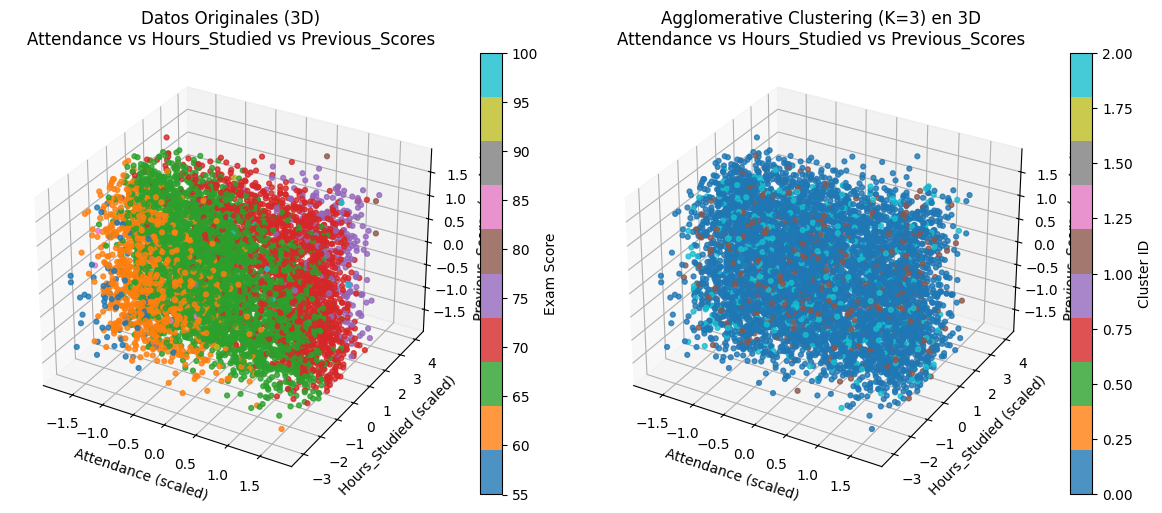

In [108]:
# @title Gráficación 3D de los datos a partir de las variables de mejor correlación

# Variables base
att = X_scaled_df['Attendance']
hrs = X_scaled_df['Hours_Studied']
prev = X_scaled_df['Previous_Scores']

fig = plt.figure(figsize=(12, 5))


# SUBPLOT 1: Datos Originales en 3D
ax1 = fig.add_subplot(121, projection='3d')

scatter1 = ax1.scatter(
    att,
    hrs,
    prev,
    c=y,               # color por nota real
    cmap='tab10',
    s=12,
    alpha=0.8
)

ax1.set_title("Datos Originales (3D)\nAttendance vs Hours_Studied vs Previous_Scores")
ax1.set_xlabel("Attendance (scaled)")
ax1.set_ylabel("Hours_Studied (scaled)")
ax1.set_zlabel("Previous_Scores (scaled)")
cbar1 = fig.colorbar(scatter1, ax=ax1)
cbar1.set_label("Exam Score")


# SUBPLOT 2: Agglomerative Clustering en 3D
ax2 = fig.add_subplot(122, projection='3d')

scatter2 = ax2.scatter(
    att,
    hrs,
    prev,
    c=agg_labels,       # color por cluster
    cmap='tab10',
    s=12,
    alpha=0.8
)

ax2.set_title("Agglomerative Clustering (K=3) en 3D\nAttendance vs Hours_Studied vs Previous_Scores")
ax2.set_xlabel("Attendance (scaled)")
ax2.set_ylabel("Hours_Studied (scaled)")
ax2.set_zlabel("Previous_Scores (scaled)")
cbar2 = fig.colorbar(scatter2, ax=ax2)
cbar2.set_label("Cluster ID")

plt.tight_layout()
plt.show()

In [101]:
# @title Score para Agglomerative Clustering
silhouette_agg = silhouette_score(X_scaled_df, agg_labels)
print("Score: ",silhouette_agg)

Score:  0.13639840566746111


<h3> <b> Análisis </b> </h3>
El clustering jerárquico fue ajustado seleccionando K = 3 clusters, decisión basada en la inspección del dendrograma construido sobre una muestra representativa de los datos. En él se observaron dos saltos verticales grandes que indican divisiones naturales alrededor de 2 o 3 agrupaciones. Elegir 3 clusters permite capturar la primera separación estructural importante sin sobresegmentar el dataset.

Una vez aplicado al conjunto completo de estudiantes, Agglomerative produjo tres grupos distribuidos de manera más equilibrada que los clusters obtenidos por K-Means o DBSCAN. En la visualización sobre las variables Attendance y Hours_Studied, se aprecia que los clusters presentan solapamiento.

## **Análisis general**

Comparación de algoritmos de clustering

| Algoritmo                 | Nº de clusters | Silhouette Score |
|---------------------------|----------------|------------------|
| **K-Means (K=6)**         | 6              | **0.0573**       |
| **DBSCAN (eps=4)**        | 4 (incluye ruido) | **0.1494**   |
| **Agglomerative (K=3)**   | 3              | **0.1364**       |

Al comparar las tres técnicas de aprendizaje no supervisado, se observa que el dataset de rendimiento estudiantil no presenta clusters claramente separables, sino más bien una estructura continua sin fronteras nítidas. Esto se refleja de manera consistente en los tres algoritmos, aunque con diferentes comportamientos internos.

K-Means, aun tras elegir el número de clusters mediante Elbow Method, produjo seis grupos que en la práctica muestran una notable superposición. El Silhouette Score de 0.0573 confirma que los clusters no están bien definidos, lo cual se aprecia visualmente en el plano formado por Attendance y Hours_Studied, donde la segmentación resulta relativamente arbitraria.

DBSCAN, por su parte, identificó un único cluster masivo junto con algunos micro-clusters y puntos marcados como ruido. El Silhouette Score de 0.1494, aunque superior al de K-Means, refleja que DBSCAN no encontró múltiples regiones densas bien separadas, la estructura de los datos es esencialmente homogénea, captando solo pequeñas islas de densidad.

Para Agglomerative Clustering el clustering jerárquico no logró una segmentación claramente interpretable del dataset. Si bien Agglomerative Clustering obtuvo un Silhouette Score de 0.1364, ligeramente superior al de K-Means y comparable al de DBSCAN, este valor sigue estando dentro de un rango que indica poca separación real entre los grupos. En la visualización 2D utilizando Attendance y Hours_Studied, los tres clusters aparecen altamente solapados, sin fronteras reconocibles o patrones distintivos, mostrando un comportamiento muy similar al de los demás algoritmos.

# **Reducción de dimensionalidad**

In [27]:
#@title Partición y preparación del dataset

# Copia del DataFrame
df_r = df_encoded.copy()

# Variables predictoras (todas menos Exam_Score)
X = df_r.drop(['Exam_Score'], axis=1)

# Variable objetivo
y = df_r['Exam_Score']

# Partición inicial Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 80% train - 20% test
    random_state=42
)

# Escalador
scaler = StandardScaler()

# Ajuste del escalador con X_train y X_test (sin fit)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lo colocamos como dataframe para mayor comodidad
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Todos los datos escalados para t-SNE
X_scaled = np.vstack([X_train_scaled, X_test_scaled])

y_full = pd.concat([y_train, y_test], axis=0).values

## **PCA**


 Varianza acumulada: 0.11489683569481018 



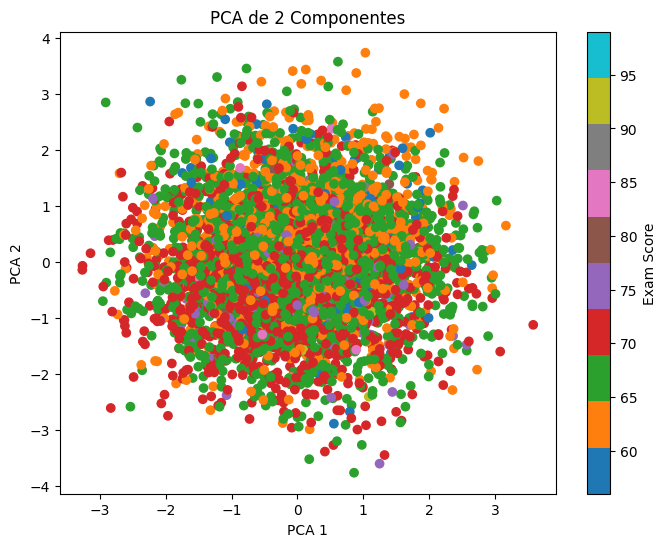

In [111]:
# @title Redución de la dimensionalidad de los datos **con solo dos componentes**

# PCA con solo 2 componentes
pca_2 = PCA(n_components=2)
X_train_pca2 = pca_2.fit_transform(X_train_scaled)

# Varianza explicada
varianza_2 = pca_2.explained_variance_ratio_
varianza_acumulada_2 = varianza_2.sum()
print(f"\n Varianza acumulada: {varianza_acumulada_2} \n")

plt.figure(figsize=(8,6))
plt.scatter(X_train_pca2[:,0], X_train_pca2[:,1], c=y_train, cmap='tab10')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA de 2 Componentes")
plt.colorbar(label='Exam Score')
plt.show()

<h4>La varianza acumulada que se entrega muestra que se toma muy poca información de los datos y la gráfica es un demostrativo del gran ruido de los datos con dos componentes

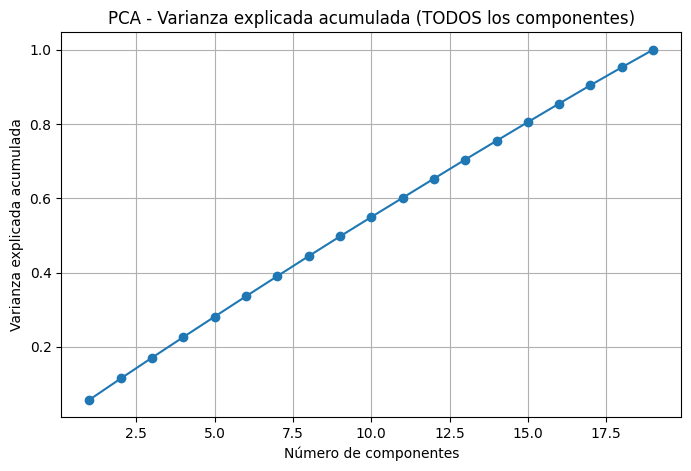

[0.05776323 0.11489684 0.17100217 0.22648032 0.28151864 0.33632818
 0.39045692 0.44427964 0.49735114 0.5495587  0.60123741 0.65286399
 0.70425772 0.75480878 0.80519306 0.85499739 0.90444399 0.9526517
 1.        ]

 Número mínimo de componentes para llegar al 95%: 18 

 Número mínimo de componentes para llegar al 99%: 19 


In [22]:
# @title PCA usando **todos los componentes**

pca_full = PCA()    # Todas los componentes
pca_full.fit(X_train_scaled)

# Varianza explicada por componente
explained_var = pca_full.explained_variance_ratio_

# Varianza acumulada
cum_var = np.cumsum(explained_var)

# Gráfico de varianza acumulada
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title('PCA - Varianza explicada acumulada (TODOS los componentes)')
plt.grid(True)
plt.show()

# Varianza acumulada
print(cum_var[:])

# Número mínimo de componentes para llegar al 90% de varianza
n_comp_90 = np.argmax(cum_var >= 0.95) + 1

# Número mínimo de componentes para llegar al 95% de varianza
n_comp_95 = np.argmax(cum_var >= 0.99) + 1

print(f"\n Número mínimo de componentes para llegar al 95%: {n_comp_90} ")
print(f"\n Número mínimo de componentes para llegar al 99%: {n_comp_95} ")

Para obtener un gran margen (99%) se usa 19 componentes (es decir todos) y aprovechar todos los datos

In [23]:
# PCA con 19 componentes
pca_final = PCA(n_components=19) # podria ser simplemente pca_final = PCA()

# Ajustamos y transformamos TRAIN
X_train_pca = pca_final.fit_transform(X_train_scaled)

# Transformamos TEST
X_test_pca = pca_final.transform(X_test_scaled)

X_train_pca.shape, X_test_pca.shape

((5101, 19), (1276, 19))

In [24]:
# @title Función de regresion
def flujo_regresion(modelo, param_grid, score, X_train, X_test, y_train, y_test):

  # Validación cruzada
  cv = KFold(n_splits=5, shuffle=True, random_state=42)

  # Tuning con grid_search
  grid = GridSearchCV(
      estimator=modelo,
      param_grid=param_grid,
      cv=cv,
      scoring= score,
      n_jobs=-1,
      return_train_score=True
  )

  # Entrenamiento del GridSearch
  grid.fit(X_train, y_train)

  # Obtención del mejor modelo
  mejor_modelo = grid.best_estimator_

  # Metricas de cada fold del mejor modelo
  scores_folds = cross_val_score(
      mejor_modelo, X_train, y_train,
      cv=cv,
      scoring= score
  )

  # Entrenamiento del modelo fina con todo el x_train y evaluar con el test
  mejor_modelo.fit(X_train, y_train)
  y_pred = mejor_modelo.predict(X_test)

  absolte_error = mean_absolute_error(y_test, y_pred)
  mean_squared = mean_squared_error(y_test, y_pred)

  return grid, scores_folds, absolte_error, mean_squared, y_pred

In [25]:
# @title Entrenamiento **CON PCA** con SVR
# Modelo base
svr = SVR()

# Grid de hiperparámetros
param_grid = {
    'kernel': ['rbf','sigmoid'],
    'gamma': [0.001, 0.01, 0.1, 1]
}

# Métrica
score = make_scorer(mean_absolute_error, greater_is_better=False)

# Llamado del flujo usando datos PCA
grid_pca, scores_folds_pca, absolte_error_pca, mean_squared_pca, y_pred_pca = flujo_regresion(
    svr,
    param_grid,
    score,
    X_train_pca,
    X_test_pca,
    y_train,
    y_test
)

print("Mejores hiperparámetros (PCA):", grid_pca.best_params_)
print("Mejor evaluación promedio (PCA):", -grid_pca.best_score_)

print("\n \n Evaluación final con PCA:")
print("MAE:", round(absolte_error_pca, 4))
print("MSE:", round(mean_squared_pca, 4))

Mejores hiperparámetros (PCA): {'gamma': 0.01, 'kernel': 'sigmoid'}
Mejor evaluación promedio (PCA): 0.4447968911079661

 
 Evaluación final con PCA:
MAE: 0.4298
MSE: 4.126


In [26]:
# @title Entrenamiento **SIN PCA** con SVR

# Modelo base
svr = SVR()

# Definición del grid de hiperparámetros
param_grid = {
    'kernel': ['rbf','sigmoid'],
    'gamma': [0.001, 0.01, 0.1, 1]
}

# Metrica de mejora del modelo
score = make_scorer(mean_absolute_error, greater_is_better=False)
# Llamado de la función
grid, scores_folds, absolte_error, mean_squared, y_pred = flujo_regresion(svr, param_grid, score, X_train, X_test, y_train, y_test)

# Mejores hiperparametros
print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor evaluación promedio:", -grid.best_score_)

# Evaluacion final del mejor modelo
print("\n\nEvaluación final:")
print("MAE:", round(absolte_error, 4))
print("MSE:", round(mean_squared, 4))

Mejores hiperparámetros: {'gamma': 0.001, 'kernel': 'rbf'}
Mejor evaluación promedio: 0.6500471053963317


Evaluación final:
MAE: 0.5832
MSE: 4.32


### Comparación de rendimiento del modelo SVR con y sin PCA

| Modelo                     | MAE    | MSE    |
|----------------------------|--------|--------|
| SVR sin reducción (original) | 0.5832 | 4.3200 |
| SVR con PCA (19 componentes) | 0.4298 | 4.1260 |


<h2><b>Análisis referente al PCA</b></h2>

En el caso del rendimiento estudiantil, se entrenó un modelo SVR tanto con las características originales como con las características transformadas mediante PCA. Al utilizar PCA con 19 componentes principales, el modelo obtuvo un MAE de 0.4298 y un MSE de 4.126, mientras que con las características originales el MAE fue de 0.5832 y el MSE de 4.32. Es decir, la reducción de dimensionalidad en forma de PCA mejoró el rendimiento del modelo, reduciendo el error medio y el error cuadrático medio. Aunque en este caso la “reducción” no es muy fuerte (se usan todas las componentes), la transformación a componentes ortogonales parece ayudar al SVR a ajustar mejor la relación entre las variables explicativas y la nota de examen, posiblemente al eliminar correlaciones y ruido entre las características originales.

## **t-SNE:**

In [28]:
# Comprobación de dimensiones del X escalada y el y completo
X_scaled.shape, y_full.shape

((6377, 19), (6377,))

In [31]:
# @title Aplicación de t-SNE a dos componentes

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1000,
    random_state=42
)

X_tsne = tsne.fit_transform(X_scaled)
X_tsne.shape

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


(6377, 2)

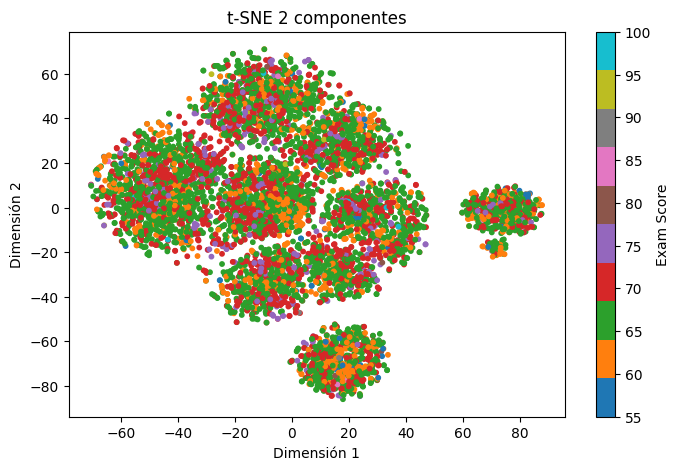

In [112]:
# @title Visualización de las dos componentes
plt.figure(figsize=(8,5))
plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=y_full,
    cmap='tab10',
    s=10
)

plt.colorbar(label="Exam Score")
plt.title("t-SNE 2 componentes")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")
plt.show()

In [34]:
# @title **Train/Test pero en el espacio t-SNE**
X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = train_test_split(
    X_tsne,
    y_full,
    test_size=0.2,
    random_state=42
)

X_train_tsne.shape, X_test_tsne.shape

((5101, 2), (1276, 2))

In [35]:
# @title Entrenamiento **CON t-SNE** con SVR

svr = SVR()

param_grid = {
    'kernel': ['rbf', 'sigmoid'],
    'gamma': [0.001, 0.01, 0.1, 1]
}

score = make_scorer(mean_absolute_error, greater_is_better=False)

grid_tsne, scores_folds_tsne, absolte_error_tsne, mean_squared_tsne, y_pred_tsne = flujo_regresion(
    svr,
    param_grid,
    score,
    X_train_tsne,
    X_test_tsne,
    y_train_tsne,
    y_test_tsne
)

print("Mejores hiperparámetros (t-SNE):", grid_tsne.best_params_)
print("Mejor evaluación promedio (t-SNE):", -grid_tsne.best_score_)

print("Evaluación final (t-SNE):")
print("MAE:", round(absolte_error_tsne, 4))
print("MSE:", round(mean_squared_tsne, 4))

Mejores hiperparámetros (t-SNE): {'gamma': 0.1, 'kernel': 'rbf'}
Mejor evaluación promedio (t-SNE): 2.322187488370398
Evaluación final (t-SNE):
MAE: 2.1927
MSE: 8.2685


### Comparación de rendimiento del modelo SVR

| Representación de los datos     | MAE    | MSE    |
|---------------------------------|--------|--------|
| Sin reducción (características originales) | 0.5832 | 4.3200 |
| PCA (19 componentes principales)          | 0.4298 | 4.1260 |
| t-SNE (2 dimensiones)                     | 2.1927 | 8.2685 |


El modelo con t-SNE muestra un menor rendimiento a comparación del entrenamiento sin reducción de dimensión. El análisis se hará en ANÁLISIS GENERAL

## **Análisis general**



En el caso de PCA, se realizaron dos ejercicios: una reducción inicial a 2 componentes para visualización, donde solo se explicó el 11% de la varianza y se observó una fuerte pérdida de información y una reducción final a 19 componentes, manteniendo casi el 100% de la varianza del dataset. Al entrenar el modelo SVR sobre estas 19 componentes, se obtuvo un MAE de 0.4298 y un MSE de 4.126, mejorando el rendimiento obtenido con las características originales (MAE 0.5832, MSE 4.32).

Por otro lado, t-SNE se aplicó exclusivamente para generar una representación visual del dataset en 2 dimensiones, ya que esta técnica está diseñada para mantener relaciones locales y formar clusters visuales, no para preservar la estructura global del espacio ni la varianza. Aunque la visualización resultante mostró agrupamientos interesantes, el uso de t-SNE como transformador previo al modelo supervisado produjo resultados muy inferiores a los modelos entrenados con los datos originales o con PCA. Esto ocurre porque t-SNE está optimizado para visualización y no genera un espacio linealmente consistente o apto para modelado.

Comparando las tres representaciones (datos originales, PCA y t-SNE), se observó que la mejor estrategia para este problema de regresión fue el uso de PCA con 19 componentes, que permitió mejorar las métricas respecto al modelo basado en los datos originales, aunque la reducción de dimensionalidad fue mínima. La proyección t-SNE evidenció ser una herramienta útil para visualización, pero inadecuada para alimentar modelos supervisados, ya que desmejoró el rendimiento del SVR. En general,  la reducción de dimensionalidad puede mejorar un modelo siempre que preserve estructura relevante para la tarea (como PCA en este caso).